# Density simulation of a McKean-Vlasov SDE with double layer potential


This notebook implements the simulations described in Section 3.2 of 

- Hoffmann, M. and Liu, Y (2023). A statistical approach for simulating the density solution of a McKean-Vlasov equation. 

-------------------------------

**Contents**

* [1. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme](#chapter1)

* [2. Density simulation with Gaussian-based high order Kernels](#chapter2)

    * [2.1 Definition of Gaussian-based high order Kernels](#section2-1)
    
    * [2.2 Data-driven bandwidth selection](#section2-2)
    
    * [2.3 Gaussian Kernel ( Kernel Order = 1 )](#section2-3)
    
    * [2.4 Kernel Order = 3](#section2-4)
    
    * [2.5 Kernel Order = 5](#section2-5)
    
    * [2.6 Kernel Order = 7](#section2-6)
    
    * [2.7 Kernel Order = 9](#section2-7)
    
    * [2.8 Comparison of simulated densities with different kernels](#section2-8)

-------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import pandas as pd 
from scipy.stats import norm
from scipy import integrate


## 1. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme <a class="anchor" id="chapter1"></a> 


We consider a McKean-Vlasov SDE with double layer potential as described in Section 4.3 of 

* Della Maestra, L., & Hoffmann, M. (2023). The LAN property for McKean–Vlasov models in a mean-field regime. Stochastic Processes and their Applications, 155, 109-146.


The definition of the McKean-Vlasov equation is 

$$dX_t= \Big(\int_\mathbb{R} U_\theta'(X_t-y)\mu_t(dy)\Big)dt+\sigma dB_t,\quad X_0=0,\hspace{2cm}(1)$$

where the potential function $U_{\theta}(x)$ is defined by  

$$U_\theta(x)=-\theta_1 e^{-\theta_2 x^2}+\theta_3 e^{-\theta_4 x^2}$$
    
with parameter $\theta=(\theta_1, \theta_2, \theta_3, \theta_4)$ and the derivative

$$U'_\theta (x)=-\theta_1\exp(-\theta_2 x^2)(-2\theta_2 x)+\theta_3 \exp(-\theta_4 x^2)(-2\theta_4 x).$$


Let $N$ be the number of particles. The $N$-particle system $(X_t^{1}, ..., X_t^{N})_{t\in[0,T]}$ corresponding to Equation (1) is defined as follows :

$$dX_t^{n}=\frac{1}{N}\sum_{j=1}^{N}U'_\theta (X_t^n-X_t^j) \,dt+\sigma dB_t^n.\hspace{2cm}(2)$$
    
Let $M$ denote the time discretization number for the Euler scheme. Set $h=\frac{T}{M}$ and $t_m=m\cdot h, 0\leq m\leq M$. Combining the particle system (2) and the Euler scheme, we obtain the following discrete particle system :

$$\bar{X}_{t_{m+1}}^{n,h}=\bar{X}_{t_{m}}^{n,h}+h\cdot\frac{1}{N}\sum_{j=1}^{N}U'_\theta (\bar{X}_{t_{m}}^{n,h}-\bar{X}_{t_{m}}^{j,h}) +\sqrt{h}\sigma Z_{m+1}^{n},\quad 1\leq n\leq N,$$

where $ \: Z_{m+1}^{n}:=\frac{1}{\sqrt{h}}(B^n_{t_{m+1}}-B^n_{t_{m}})$ are i.i.d random variables having the standard normal distribution $\mathcal{N}(0,1)$.

* In this notebook, we fix $d=1$, $\theta=(1,1,2,2)$, $\sigma=1$ for the McKean-Vlasov equation, and fix $T=1$ and $M=100$ for the time discretization.



In [ ]:
# Parameters of the McKean-Vlasov equation

sigma=1
theta1=1
theta2=1
theta3=2
theta4=2

# Parameters of the time discretization 

T=1. 
M=100  # Time discretization number
h=T/M  # Time step

In the next cell, we define the potential function $U$ by `U_fun` and its derivative by `U_prime`. We also shows the curve of the potential function $U$ (in red) and that of its derivative (in blue).

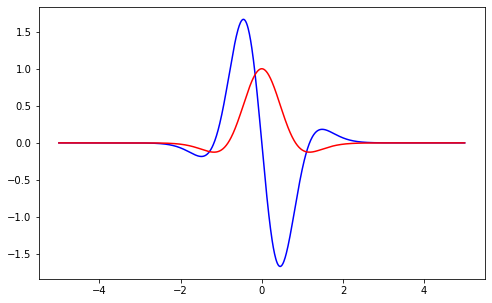

In [ ]:
# The potential function 

def U_fun(x):
    return -theta1*np.exp(-theta2*(x)**2)+theta3*np.exp(-theta4*x**2)

def U_prime(x):
    return -theta1*np.exp(-theta2*x**2)*(-2*theta2*x)+theta3*np.exp(-theta4*x**2)*(-2*theta4*x)


curve_xx=np.linspace(-5,5,1000)

U_prime_curve=U_prime(curve_xx)
U_fun_curve=U_fun(curve_xx)

plt.figure(figsize = (8,5))
plt.plot(curve_xx,U_prime_curve,"b")
plt.plot(curve_xx,U_fun_curve,"r")
plt.savefig('u_fun_and_u_prime.png')


In the next cell, the function `Euler_one_step` defines the operator of the Euler scheme for one time step.

In [ ]:
# One step Euler scheme

def Euler_one_step(X_in,N_in):
    X_out=np.zeros(N_in)
    
    for i in range(N_in):
        uin=X_in[i]-X_in
        uu=U_prime(uin).sum()
        X_out[i]=X_in[i]+h*uu/N_in+np.sqrt(h)*sigma*np.random.normal(0, 1, 1)
    return X_out

We consider different particle numbers : $N\in\{2^5=32, 2^6=64, ..., 2^{16}=65536\}$. 


In [ ]:
pn=12
N_power=np.linspace(5,16,pn) 
print (N_power)

N_vec=2**N_power.astype(int) # Number of particles, from 2^5 to 2^16
print (N_vec)

[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[   32    64   128   256   512  1024  2048  4096  8192 16384 32768 65536]


First, we compute and save the particle systems at time T=1 with different particle numbers in `N_vec`. 

In [ ]:
# Compute the particle at time T=1

for i in tqdm(range(pn)):
    particle_process=np.zeros((N_vec[i],M))
#    particle_process[:,0]=np.random.normal(0, 0.01, N_vec[i]) # The initial distribution for X_0 is N(0,0.01). 
    for m in range(M-1):
        particle_process[:,m+1]=Euler_one_step(particle_process[:,m],N_vec[i])
    
    np.savetxt("particle_number_"+str(N_vec[i])+".csv", particle_process[:,-1], delimiter=",")

100%|████████████████████████████████████████| 11/11 [1:01:46<00:00, 336.91s/it]


-------------------

# 2. Density simulation with Gaussian-based high order Kernel <a class="anchor" id="chapter2"></a> 

## 2.1 Definition of Gaussian-based high order kernel <a class="anchor" id="section2-1"></a> 



The Gaussian-based high order kernels that we use in this notebook are 
- Order 1 : $\phi(x)=\frac{1}{\sqrt{2\pi}}\exp\big(-\frac{x^2}{2}\big)$



- Order 3 : $\frac{1}{2}(3-x^2)\,\phi(x)$



- Order 5 : $\frac{1}{8}(15-10x^2+x^4)\,\phi(x)$



- Order 7 : $\frac{1}{48}(105-105x^2+21x^4-x^6)\,\phi(x)$



- Order 9 : $\frac{1}{384}(945-1260x^2+378x^4-36x^6+x^8)\,\phi(x)$


which are defined in the following paper (see Table 1):

- Wand, Matthew P., and William R. Schucany. "Gaussian‐based kernels." Canadian Journal of Statistics 18, no. 3 (1990): 197-204.



In [ ]:
# Kernel order 1

def kernel_O1(x_in):
    return np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O1_fun = lambda x: np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 3

def kernel_O3(x_in):
    return 0.5*(3-x_in**2)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O3_fun = lambda x: 0.5*(3-x**2)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 5

def kernel_O5(x_in):
    return (15-10*x_in**2+x_in**4)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/8

kernel_O5_fun = lambda x: (15-10*x**2+x**4)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/8

# Kernel order 7

def kernel_O7(x_in):
    return (105-105*x_in**2+21*x_in**4-x_in**6)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/48

kernel_O7_fun = lambda x: (105-105*x**2+21*x**4-x**6)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/48

# Kernel order 9

def kernel_O9(x_in):
    return (945-1260*x_in**2+378*x_in**4-36*x_in**6+x_in**8)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/384

kernel_O9_fun = lambda x: (945-1260*x**2+378*x**4-36*x**6+x**8)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/384


The next cell shows the curves of different kernels.

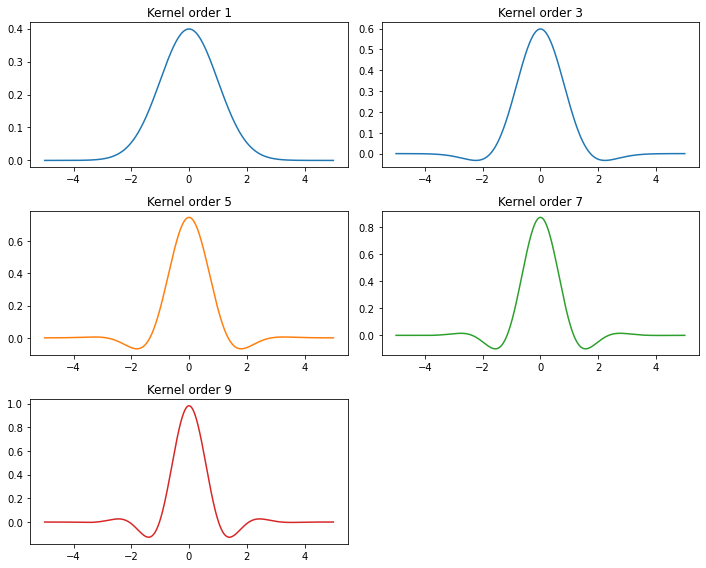

In [ ]:
test_xx=np.linspace(-5,5,1000)
Kernel_O1_plot=kernel_O1_fun(test_xx)
Kernel_O3_plot=kernel_O3_fun(test_xx)
Kernel_O5_plot=kernel_O5_fun(test_xx)
Kernel_O7_plot=kernel_O7_fun(test_xx)
Kernel_O9_plot=kernel_O9_fun(test_xx)


fig, axs = plt.subplots(3, 2, figsize=(10,8))
axs[0, 0].plot(test_xx, Kernel_O1_plot)
axs[0, 0].set_title('Kernel order 1')
axs[0, 1].plot(test_xx, Kernel_O3_plot)
axs[0, 1].set_title('Kernel order 3')
axs[1, 0].plot(test_xx, Kernel_O5_plot, 'tab:orange')
axs[1, 0].set_title('Kernel order 5')
axs[1, 1].plot(test_xx, Kernel_O7_plot, 'tab:green')
axs[1, 1].set_title('Kernel order 7')
axs[2, 0].plot(test_xx, Kernel_O9_plot, 'tab:red')
axs[2, 0].set_title('Kernel order 9')
axs[2, 1].axis('off')
fig.tight_layout()

plt.savefig('gaussian_high_order_kernel.png')

The next cell computes the $L^2-$norm of different kernels $|K|_{L^2}=(\int_{\mathbb{R}}|x|^2dx)^{1/2}$. 

In [ ]:
# Kernel order 1

kernel_O1_fun_square = lambda x: (np.exp(-0.5*(x**2))/np.sqrt(2*np.pi))**2

normL2_O1 = integrate.quad(kernel_O1_fun_square, -np.inf, np.inf)[0]
print (normL2_O1)

# Kernel order 3

kernel_O3_fun_square = lambda x: (0.5*(3-x**2)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi))**2

normL2_O3 = integrate.quad(kernel_O3_fun_square, -np.inf, np.inf)[0]
print (normL2_O3)

# Kernel order 5

kernel_O5_fun_square = lambda x: ((15-10*x**2+x**4)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/8)**2

normL2_O5 = integrate.quad(kernel_O5_fun_square, -np.inf, np.inf)[0]
print (normL2_O5)

# Kernel order 7

kernel_O7_fun_square = lambda x: ((105-105*x**2+21*x**4-x**6)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/48)**2

normL2_O7 = integrate.quad(kernel_O7_fun_square, -np.inf, np.inf)[0]
print (normL2_O7)

# Kernel order 9

kernel_O9_fun_square = lambda x: ((945-1260*x**2+378*x**4-36*x**6+x**8)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/384)**2

normL2_O9 = integrate.quad(kernel_O9_fun_square, -np.inf, np.inf)[0]
print (normL2_O9)

0.28209479177387786
0.47603496111841886
0.623969436882652
0.7478507861754393
0.8564800110622434


## 2.2 Data-driven bandwidth selection <a class="anchor" id="section2-2"></a> 

The following cells implement the data-driven bandwidth selection strategies, as described in Theorem 2.12 and Corollary 2.13 of [Hoffmann, M. and Liu, Y (2023)]. 


The function `H_set_func` compute the bandwidth set $\mathcal{H}$ defined in Corollary 2.13, i.e.

$$\mathcal{H}=\Big\{\; \big(\frac{N}{\log N}\big)^{-\frac{1}{2m+d}} ,\; m=1, ..., l+1\;\Big\},$$

where $l$ denotes the order of the kernel. The output of the function `H_set_func` is ordered increasingly. 



In [ ]:
def H_set_func(N_in,l_regularity_plus_one):
    h_value=np.zeros(l_regularity_plus_one)
    for i in range(l_regularity_plus_one):
        ind=-1./(2*(i+1)+1)
        h_value[i]=(N_in/np.log(N_in))**ind
    h_order=np.sort(h_value)
    return h_order

For the particle system $(\bar{X}_{T}^{1,h}, ..., \bar{X}_{T}^{N,h})$ at time T, for every bandwidth $\eta$ in the bandwidth set $\mathcal{H}$, and for the fixed input kernel $K$, the output of the function `KDE_fun_s` in the next cell are simulated density functions defined in Section 2.2 : 


$$\Big\{\; x\mapsto \widehat{\mu}_T^{N, h, \eta}(x):= \frac{1}{N}\sum_{n=1}^{N}\eta^{-d}K\big(\eta^{-1}(x-\bar{X}_T^{n,h})\big),\quad  \eta \in \mathcal{H}\;\Big\}.$$


In [ ]:
# The following function is the density estimation function with a fixed input kernel
# Input : the bandwidth_s in H_set, the kernel base K(x), the particles and the particle numbers.
# Output : the density estimation functions with reprectives bandwidths in H_set

def KDE_fun_s(particle_num_in, particle_in, kernel_base_fun_in, H_set_in):
    KDE_output=[]
    for i in range(H_set_in.size):
        eta_parameter=H_set_in[i]
        def funcC(parameter):
            def func(x_in):
                return kernel_base_fun_in((x_in-particle_in)/parameter).sum()/(particle_num_in*parameter)
            return func
        KDE_output.append(funcC(eta_parameter))
    return KDE_output



In the next cell, the function `V_value` computes $V_\eta^N$ defined in (14), i.e. 

$$V_\eta^N=\bar{w}|K|_{L^2}^2(\log N)N^{-1}\eta^{-d},$$

where $\bar{w}$ is a pre-factor, $K$ is the kernel, $N$ is the particle number and $\eta$ is the bandwidth.

In [ ]:
# We compute the value of V_eta^N, which depends on the pre-factor w_bar

def V_value(eta_in, N_in, kernel_norm_square_in):
    return w_bar*kernel_norm_square_in*np.log(N_in)/(N_in*eta_in)



In the next cell, the function `A_value` computes $A_{\eta}^{N}(T=1,x)$ for given $x\in\mathbb{R}$ with respect to the following formula 

$$A_{\eta}^{N}(t,x)=\max_{\eta'\leq \eta, \eta'\in\mathcal{H}}\Big\{ \;\big(\widehat{\mu}_{t}^{N, h, \eta}(x)-\widehat{\mu}_{t}^{N, h, \eta'}(x)\big)^2-(V_{\eta}^N+V_{\eta'}^{N})\Big\}_{+},$$

where $\{x\}_{+}=\max(x,0)$, $\mathcal{H}$ is an input bandwidth set, $V_{\eta}^{N}$ is defined in the previous cell and $\widehat{\mu}_T^{N, h, \eta}(x):= \frac{1}{N}\sum_{n=1}^{N}\eta^{-d}K\big(\eta^{-1}(x-\bar{X}_T^{n,h})\big)$ is the simulated density function. 

In [ ]:
def A_value(particle_num_in, KDE_fun_s_in, H_set_in, kernel_norm_square_in, eta_in, x_in):
    A_vector=[]
    index=np.where(H_set_in==eta_in)[0][0]
    if index == 0:
        print ("Attention ! A_value(eta_0)==0, no need compute ! ")
    for i in range(index):
        append_in_part1=(KDE_fun_s_in[index](x_in)-KDE_fun_s_in[i](x_in))**2
        append_in_part2=V_value(eta_in, particle_num_in, kernel_norm_square_in)+V_value(H_set_in[i], particle_num_in, kernel_norm_square_in)
        A_vector.append(max(append_in_part1-append_in_part2,0))
    return max(A_vector)



The following cell gives the optimal choice of the bandwidth (formula (15) in the paper)

$$\widehat{\eta}^{N}(T=1,x)\in\text{argmin}_{\eta\in\mathcal{H}}\big( A_{\eta}^{N}(T=1, x)+V_{\eta}^{N}\big)\;. $$

In [ ]:
def determine_fun(V_vector_in, A_vector_in, H_set_in):
    S_vector=V_vector_in+A_vector_in
    choice=np.argmin(S_vector)
    return (choice+1)  # choice+1 because Python counts from 0 

-----------------------


## Organisation for Sections 2.3, 2.4, 2.5, 2.6 and 2.7

Sections 2.3, 2.4, 2.5, 2.6 and 2.7 have similar organisation: 

**(A)** The first part of each section displays the distrubtion (in histogram) of optimal bandwidths.

We pick several values for the pre-factor $\bar{w}\in\big\{\frac{1}{20}, \frac{1}{10}, 1, 10,20\big\}$ and compute the distrubtion of optimal bandwidths $\widehat{\eta}^{N}(T, x)$ in 

\begin{equation}
\mathcal{H}=\Big\{\; \big(\frac{N}{\log N}\big)^{-\frac{1}{2m+d}} ,\; m=1, ..., l+1\;\Big\} \qquad \text{(see Corollary 2.13)}
\end{equation}

for $T=1$, $d=1$, $N\in \{2^5=32,2^6=64,..., 2^{16}=65536\}$, and for $x$ in a discrete grid of 100 points in some subset $D\in\mathbb{R}$. 

- We then have 1200 experiments in total. 

- Here we choose $D=[-4, 4]$ and $D=[-0.5, 0.5]$. The first choice is for a general study of the data-driven choice distribution, since the mass of $\bar{\mu}^{N,h}_T$ is concentrated in $[-4, 4]$. The second choice is for a further comparison with another dynamics having an added singular shock in the drift $b$. 


        
       
    
**(B)** The second part of each section shows the simulated density functions with respect to the optimal bandwidth $\widehat{\eta}^{N}(T=1, x)$, chosen from the above set $\mathcal{H}$, for the fixed pre-factor $\bar{w}=23$. 
    
- The ad-hoc choice $\bar{w}=23$ is quite arbitrary, the values of the data-driven bandwidths showing stability as soon as $\bar{w}\geq 20$.

- From the experiment in part (A), we can estimate that the optimal choice will be $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-\frac{1}{2(l+1)+1}}$ for a kernel with order $l$. We start with a verification cell of this conjecture: if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-\frac{1}{2(l+1)+1}}$, this verification cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 

-----------------------

## 2.3 Gaussian Kernel ( Kernel Order = 1 ) <a class="anchor" id="section2-3"></a> 

### (A)  Distrubtion of optimal bandwidths 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=1 

test_num_x=100
XX=np.linspace(-4,4,test_num_x)

oracle_choice_O1=np.zeros([num_w_bar,test_num_x*pn])

for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
            
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O1_fun, H_set_now)   
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O1)  
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O1, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O1[num,i_par*100+j]=determine_value

            
print ("Done!")



100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]

Done!


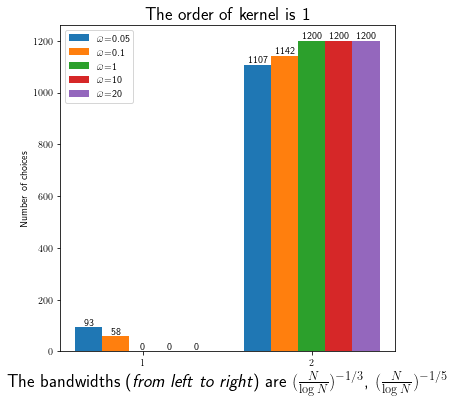

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (6,6))
bins = [0.5,1.5,2.5]

counts, edges, bars = plt.hist([oracle_choice_O1[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 1',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,3))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$

The next cell is the verification cell for the optimal bandwidth choice : if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-1/5}$, this cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 

In [ ]:
# The verification cell for the optimal bandwidth choice

w_bar=23

l_regularity=1

test_num_x=2000
XX=np.linspace(-4,4,test_num_x)

    
for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i_par in range(pn):
        Num_particle=N_vec[i_par]
        particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O1_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O1)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O1, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        if determine_value==1:
            print (x_fix, Num_particle)
            
print ("Done!")


Done!


The next two cells show the simulated density function with the Gaussian kernal and the respective optimal bandwidth $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-1/5}$ for particle number $N=2^5,\; 2^{10}, \; 2^{15}$.

In [ ]:
# plot the density simulation with the Gaussian kernel (order = 1)

w_bar=23

plot_point_number=2000

l_regularity_plus_one=2

X_plot = np.linspace(-4,4, plot_point_number)[:, np.newaxis]

# curve_1_O1 : the number of particle == 2^5 ; order = 1
curve_1_O1=np.zeros(plot_point_number)

# curve_2_O1 : the number of particle == 2^10 ; order = 1
curve_2_O1=np.zeros(plot_point_number)

# curve_3_O1 : the number of particle == 2^15 ; order = 1
curve_3_O1=np.zeros(plot_point_number)


# compute curve_1_O1 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O1
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O1
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    


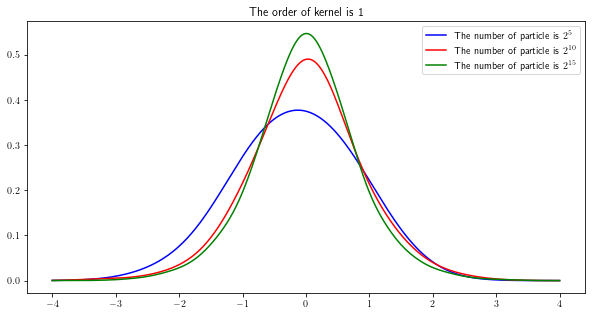

In [ ]:
plt.rcParams['text.usetex'] = True

plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O1,"b",label=r'The number of particle is $2^5$')
plt.plot(X_plot, curve_2_O1,"r",label=r'The number of particle is $2^{10}$')
plt.plot(X_plot, curve_3_O1,"green",label=r'The number of particle is $2^{15}$')

plt.title('The order of kernel is 1')

plt.legend()

## 2.4 Kernel order = 3 <a class="anchor" id="section2-4"></a> 



### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-4,4]$. 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=3 

test_num_x=100
XX=np.linspace(-4,4,test_num_x)


oracle_choice_O3=np.zeros([num_w_bar,test_num_x*pn])


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O3_fun, H_set_now)   
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O3)    
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O3, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O3[num,i_par*100+j]=determine_value

            
print ("Done!")



100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]

Done!


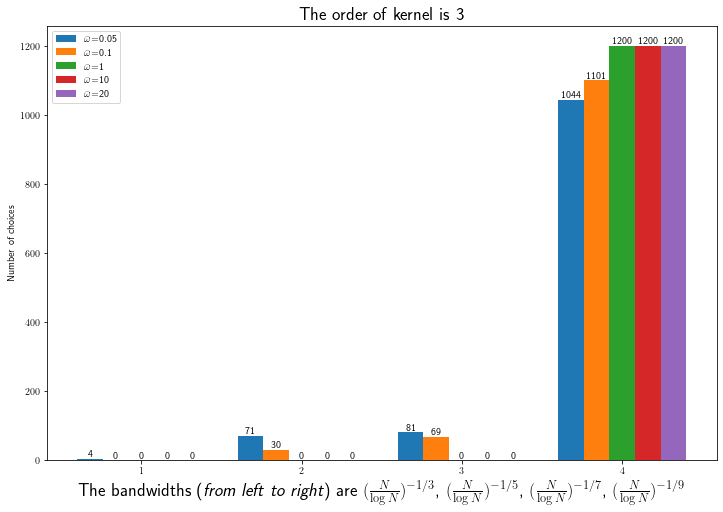

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (12,8))
bins = [0.5,1.5,2.5,3.5,4.5]

counts, edges, bars = plt.hist([oracle_choice_O3[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 3',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,5))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

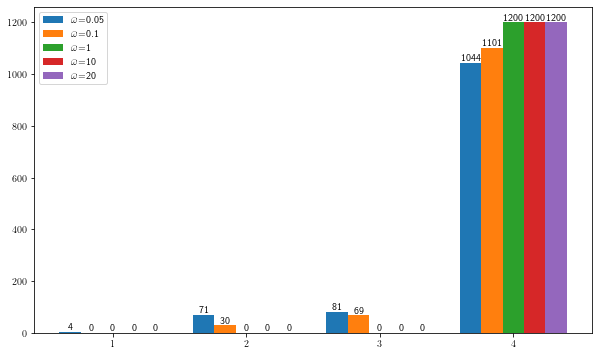

In [ ]:
# Figure 6 (Top) in the paper 

plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (10,6))
bins = [0.5,1.5,2.5,3.5,4.5]

counts, edges, bars = plt.hist([oracle_choice_O3[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

#plt.title('The order of kernel is 3',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,5))
plt.legend(loc='upper left')
#plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$',fontsize=18, color='black')
#plt.ylabel("Number of choices")

plt.savefig('distribution_bandwidth_kernel_O3.png')
plt.show()



-------------------

In the following two cells, we test for 100 values of $x$ in $[-0.5,0.5]$. 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=3 

test_num_x=100
XX=np.linspace(-0.5,0.5,test_num_x)


oracle_choice_O3_bis=np.zeros([num_w_bar,test_num_x*pn])


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O3_fun, H_set_now)  
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O3)  
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O3, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O3_bis[num,i_par*100+j]=determine_value

            
print ("Done!")



100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]

Done!


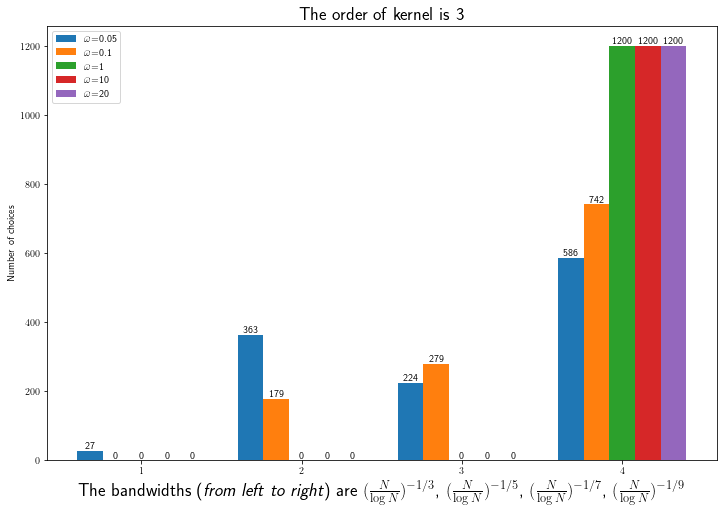

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (12,8))
bins = [0.5,1.5,2.5,3.5,4.5]

counts, edges, bars = plt.hist([oracle_choice_O3_bis[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 3',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,5))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$


The next cell is the verification cell for the optimal bandwidth choice : if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-1/9}$, this cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 


In [ ]:
# The verification cell for the optimal bandwidth choice

w_bar=23

l_regularity=3

test_num_x=2000
XX=np.linspace(-4,4,test_num_x)

    
for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i_par in range(pn):
        Num_particle=N_vec[i_par]
        particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O3_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O3)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O3, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        if determine_value!=(l_regularity+1):
            print (x_fix, Num_particle)
            
print ("Done!")


Done!


The next two cells show the simulated density function with the Gaussian kernal and the respective optimal bandwidth $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-1/9}$ for particle number $N=2^5,\; 2^{10}, \; 2^{15}$.

In [ ]:
# plot the simulation with 3-th order kernel 

w_bar=23

plot_point_number=2000

l_regularity_plus_one=4

X_plot = np.linspace(-4,4, plot_point_number)[:, np.newaxis]

# curve_1_O3 : the number of particle == 2^5 ; order = 3
curve_1_O3=np.zeros(plot_point_number)

# curve_2_O3 : the number of particle == 2^10 ; order = 3
curve_2_O3=np.zeros(plot_point_number)

# curve_3_O3 : the number of particle == 2^15 ; order = 3
curve_3_O3=np.zeros(plot_point_number)


# compute curve_1_O3 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O3 
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O3 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    


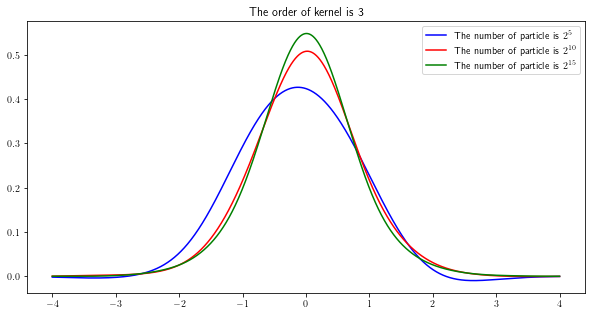

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O3,"b",label=r'The number of particle is $2^5$')
plt.plot(X_plot, curve_2_O3,"r",label=r'The number of particle is $2^{10}$')
plt.plot(X_plot, curve_3_O3,"green",label=r'The number of particle is $2^{15}$')


plt.title('The order of kernel is 3')


plt.legend()

## 2.5 Kernel order = 5 <a class="anchor" id="section2-5"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-4,4]$. 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=5 

test_num_x=100
XX=np.linspace(-4,4,test_num_x)


oracle_choice_O5=np.zeros([num_w_bar,test_num_x*pn])  # O5 for order 5 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O5_fun, H_set_now)   # Kernel_O5_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O5)    # normL2_O5 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O5, H_set_now[i+1],x_fix)# normL2_O5 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O5[num,i_par*100+j]=determine_value  # O5 for order 5 !

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [01:29<00:00, 17.98s/it]

Done!


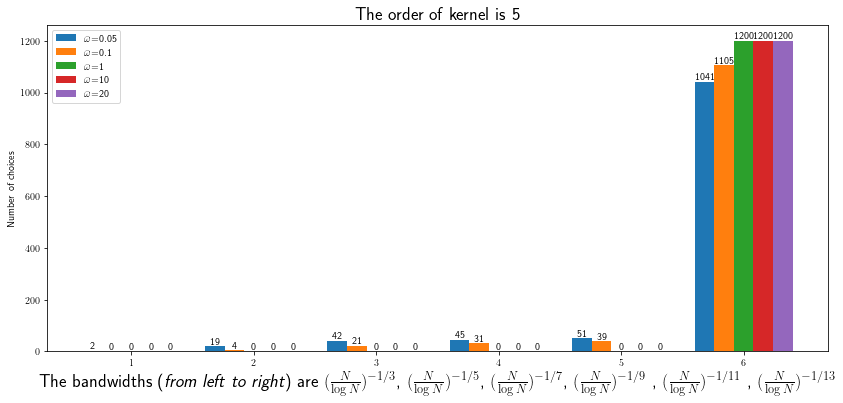

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (14,6))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]

counts, edges, bars = plt.hist([oracle_choice_O5[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 5',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,7))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

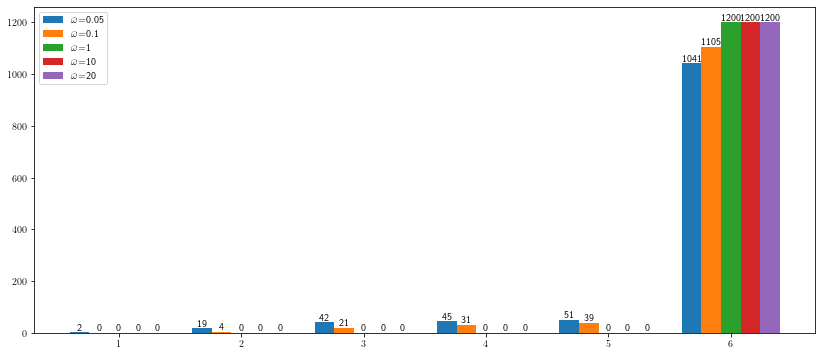

In [ ]:
# Figure 6 (Bottom) in the paper

plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (14,6))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]

counts, edges, bars = plt.hist([oracle_choice_O5[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

#plt.title('The order of kernel is 5',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,7))
plt.legend(loc='upper left')
#plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$',fontsize=18, color='black')
#plt.ylabel("Number of choices")
plt.savefig('distribution_bandwidth_kernel_O5_1.png')
plt.show()



-------------------

In the following two cells, we test for 100 values of $x$ in $[-0.5,0.5]$. 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=5 

test_num_x=100
XX=np.linspace(-0.5,0.5,test_num_x)


oracle_choice_O5_bis=np.zeros([num_w_bar,test_num_x*pn])  # O5 for order 5 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O5_fun, H_set_now)   # Kernel_O5_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O5)    # normL2_O5 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O5, H_set_now[i+1],x_fix)# normL2_O5 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O5_bis[num,i_par*100+j]=determine_value  # O5 for order 5 !

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [01:31<00:00, 18.28s/it]

Done!


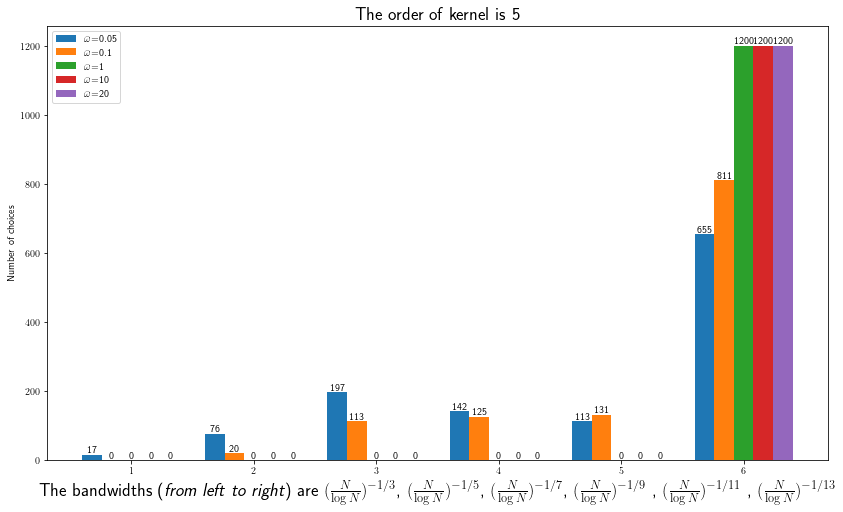

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (14,8))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]

counts, edges, bars = plt.hist([oracle_choice_O5_bis[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 5',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,7))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

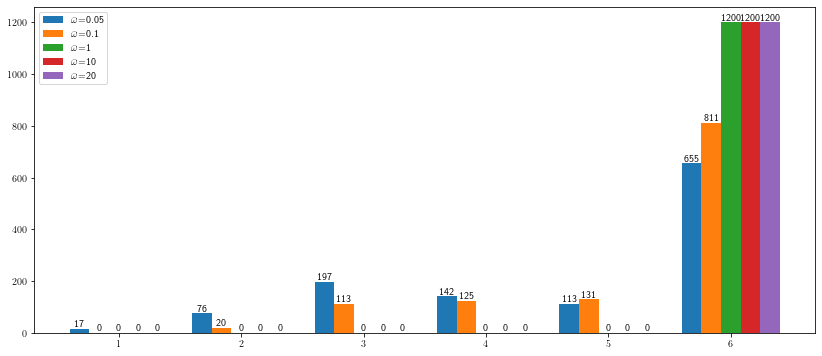

In [ ]:
# Figure 7 in the paper

plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (14,6))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]

counts, edges, bars = plt.hist([oracle_choice_O5_bis[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

#plt.title('The order of kernel is 5',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,7))
plt.legend(loc='upper left')
#plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$',fontsize=18, color='black')
#plt.ylabel("Number of choices")

plt.savefig('distribution_bandwidth_kernel_O5_2.png')
plt.show()



### (B) -  Simulated density function for $\bar{w}=23$



The next cell is the verification cell for the optimal bandwidth choice : if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-1/13}$, this cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 



In [ ]:
# The verification cell for the optimal bandwidth choice

w_bar=23

l_regularity=5

test_num_x=2000
XX=np.linspace(-4,4,test_num_x)

    
for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i_par in range(pn):
        Num_particle=N_vec[i_par]
        particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O5_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O5)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O5, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        if determine_value!=(l_regularity+1):
            print (x_fix, Num_particle)
            
print ("Done!")


Done!


he next two cells show the simulated density function with the Gaussian kernal and the respective optimal bandwidth $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-1/13}$ for particle number $N=2^5,\; 2^{10}, \; 2^{15}$.


In [ ]:
# plot the simulation with 6-th order kernel 

w_bar=23

plot_point_number=2000

l_regularity_plus_one=6

X_plot = np.linspace(-4,4, plot_point_number)[:, np.newaxis]

# curve_1_O5 : the number of particle == 2^5 ; order = 5
curve_1_O5=np.zeros(plot_point_number)

# curve_2_O5 : the number of particle == 2^10 ; order = 5
curve_2_O5=np.zeros(plot_point_number)

# curve_3_O5 : the number of particle == 2^15 ; order = 5
curve_3_O5=np.zeros(plot_point_number)


# compute curve_1_O5 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O5 
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O5 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

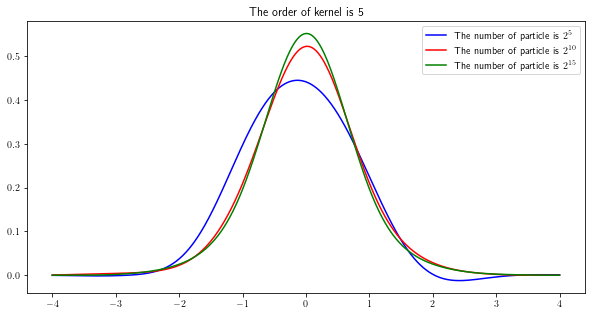

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O5,"b",label=r'The number of particle is $2^5$')
plt.plot(X_plot, curve_2_O5,"r",label=r'The number of particle is $2^{10}$')
plt.plot(X_plot, curve_3_O5,"green",label=r'The number of particle is $2^{15}$')
plt.title('The order of kernel is 5')

plt.legend()

## 2.6 Kernel order = 7 <a class="anchor" id="section2-6"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-4,4]$. 


In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=7                      # regularity !

test_num_x=100
XX=np.linspace(-4,4,test_num_x)


oracle_choice_O7=np.zeros([num_w_bar,test_num_x*pn])  # O7 for order 7 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O7_fun, H_set_now)   # Kernel_O7_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O7)    # normL2_O7 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O7, H_set_now[i+1],x_fix)# normL2_O7 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O7[num,i_par*100+j]=determine_value  # O7 for order 7 !

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [03:44<00:00, 44.83s/it]

Done!


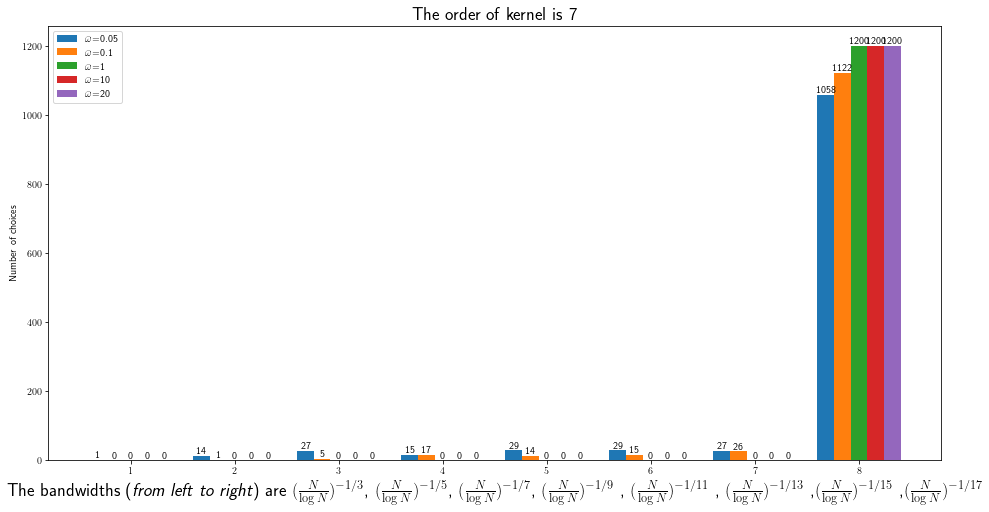

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (16,8))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

counts, edges, bars = plt.hist([oracle_choice_O7[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 7',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,9))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()


-------------------

In the following two cells, we test for 100 values of $x$ in $[-0.5,0.5]$. 

In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=7                      # regularity !

test_num_x=100
XX=np.linspace(-0.5,0.5,test_num_x)


oracle_choice_O7_bis=np.zeros([num_w_bar,test_num_x*pn])  # O7 for order 7 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O7_fun, H_set_now)   # Kernel_O7_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O7)    # normL2_O7 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O7, H_set_now[i+1],x_fix)# normL2_O7 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O7_bis[num,i_par*100+j]=determine_value  # O7 for order 7 !

            
print ("Done!")

100%|█████████████████████████████████████████████| 5/5 [03:50<00:00, 46.14s/it]

Done!


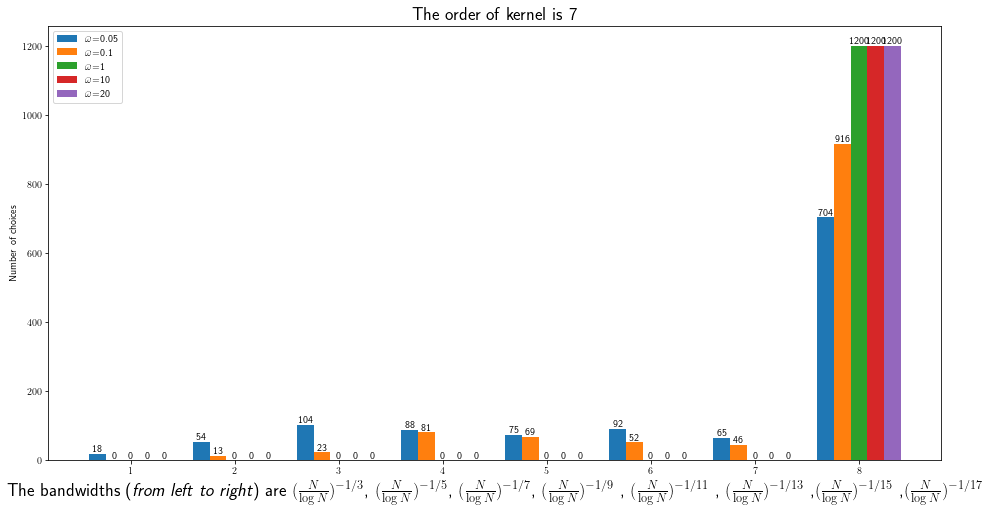

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (16,8))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

counts, edges, bars = plt.hist([oracle_choice_O7_bis[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 7',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,9))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$



The next cell is the verification cell for the optimal bandwidth choice : if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-1/17}$, this cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 



In [ ]:
# The verification cell for the optimal bandwidth choice

w_bar=23

l_regularity=7

test_num_x=2000
XX=np.linspace(-4,4,test_num_x)

    
for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i_par in range(pn):
        Num_particle=N_vec[i_par]
        particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O7_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O7)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O7, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        if determine_value!=(l_regularity+1):
            print (x_fix, Num_particle)
            
print ("Done!")

Done!


The next two cells show the simulated density function with the Gaussian kernal and the respective optimal bandwidth $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-1/17}$ for particle number $N=2^5,\; 2^{10}, \; 2^{15}$.

In [ ]:
# plot the simulation with 8-th order kernel 
w_bar=23

plot_point_number=2000

l_regularity_plus_one=8

X_plot = np.linspace(-4,4, plot_point_number)[:, np.newaxis]

# curve_1_O7 : the number of particle == 2^5 ; order = 7
curve_1_O7=np.zeros(plot_point_number)

# curve_2_O7 : the number of particle == 2^10 ; order = 7
curve_2_O7=np.zeros(plot_point_number)

# curve_3_O7 : the number of particle == 2^15 ; order = 7
curve_3_O7=np.zeros(plot_point_number)


# compute curve_1_O7
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O7 
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O7 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

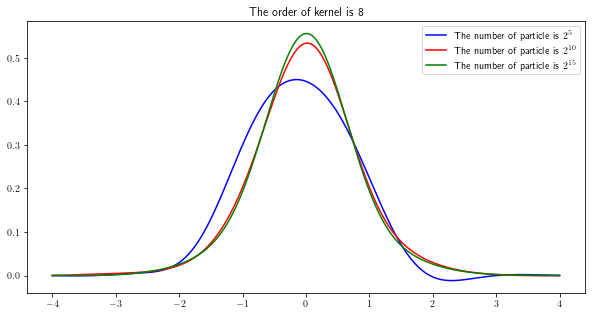

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O7,"b",label=r'The number of particle is $2^5$')
plt.plot(X_plot, curve_2_O7,"r",label=r'The number of particle is $2^{10}$')
plt.plot(X_plot, curve_3_O7,"green",label=r'The number of particle is $2^{15}$')
plt.title('The order of kernel is 8')

plt.legend()

## 2.7 Kernel order = 9 <a class="anchor" id="section2-7"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-4,4]$. 


In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=9                      # regularity !

test_num_x=100
XX=np.linspace(-4,4,test_num_x)


oracle_choice_O9=np.zeros([num_w_bar,test_num_x*pn])  # O9 for order 9 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O9_fun, H_set_now)   # Kernel_O9_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O9)    # normL2_O9 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O9, H_set_now[i+1],x_fix)# normL2_O9 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O9[num,i_par*100+j]=determine_value  # O9 for order 9 !

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [07:36<00:00, 91.30s/it]

Done!


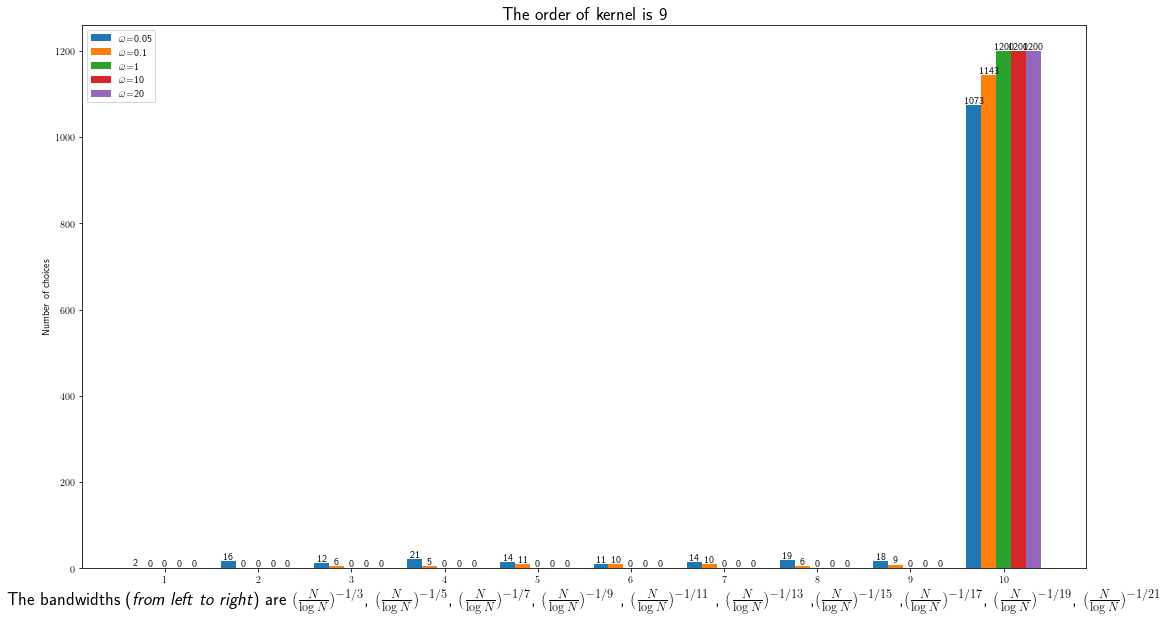

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (18,10))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]

counts, edges, bars = plt.hist([oracle_choice_O9[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 9',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,11))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$, $(\frac{N}{\log N})^{-1/19}$, $(\frac{N}{\log N})^{-1/21}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

-------------------

In the following two cells, we test for 100 values of $x$ in $[-0.5,0.5]$. 



In [ ]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=9                      # regularity !

test_num_x=100
XX=np.linspace(-0.5,0.5,test_num_x)


oracle_choice_O9_bis=np.zeros([num_w_bar,test_num_x*pn])  # O9 for order 9 !


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O9_fun, H_set_now)   # Kernel_O9_fun ! 
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O9)    # normL2_O9 !
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O9, H_set_now[i+1],x_fix)# normL2_O9 !
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O9_bis[num,i_par*100+j]=determine_value  # O9 for order 9 !

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [08:03<00:00, 96.62s/it]

Done!


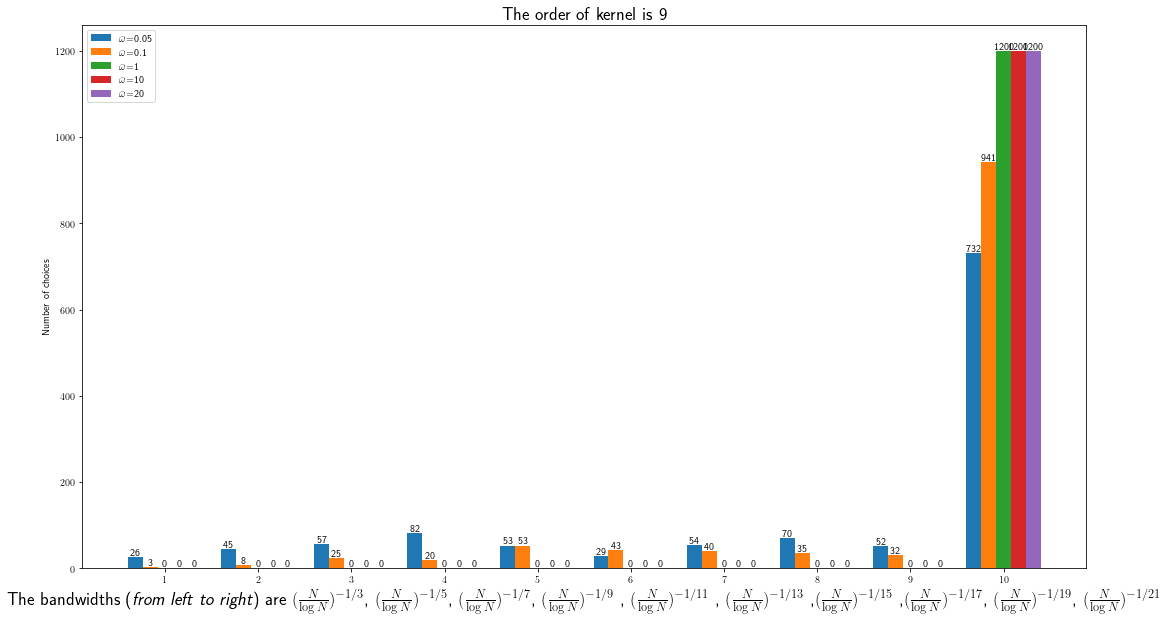

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (18,10))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]

counts, edges, bars = plt.hist([oracle_choice_O9_bis[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 9',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,11))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$, $(\frac{N}{\log N})^{-1/19}$, $(\frac{N}{\log N})^{-1/21}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()


### (B) -  Simulated density function for $\bar{w}=23$



The next cell is the verification cell for the optimal bandwidth choice : if $\widehat{\eta}^{N}(T, x)\neq\big(\frac{N}{\log{N}}\big)^{-1/21}$, this cell prints the respective $(x,N)$; else, it prints nothing but a `Done!` at the end. 


In [ ]:

# The verification cell for the optimal bandwidth choice

w_bar=23

l_regularity=9

test_num_x=2000
XX=np.linspace(-4,4,test_num_x)

    
for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i_par in range(pn):
        Num_particle=N_vec[i_par]
        particle_now = np.array(pd.read_csv("particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O9_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O9)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O9, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        if determine_value!=(l_regularity+1):
            print (x_fix, Num_particle)
            
print ("Done!")



Done!


The next two cells show the simulated density function with the Gaussian kernal and the respective optimal bandwidth $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-1/21}$ for particle number $N=2^5,\; 2^{10}, \; 2^{15}$.


In [ ]:
w_bar=23

plot_point_number=2000

l_regularity_plus_one=10

X_plot = np.linspace(-4,4, plot_point_number)[:, np.newaxis]

# curve_1_O9 : the number of particle == 2^5 ; order = 8
curve_1_O9=np.zeros(plot_point_number)

# curve_2_O9 : the number of particle == 2^10 ; order = 8
curve_2_O9=np.zeros(plot_point_number)

# curve_3_O9 : the number of particle == 2^15 ; order = 8
curve_3_O9=np.zeros(plot_point_number)


# compute curve_1_O9
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O9
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O9 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

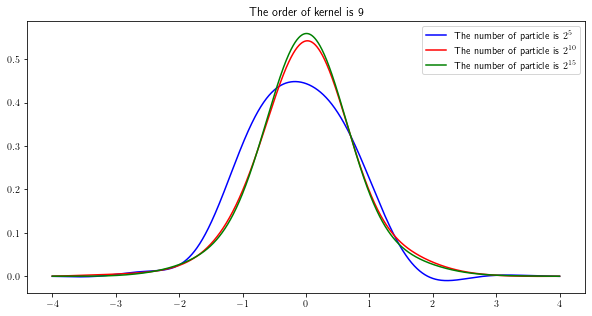

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O9,"b",label=r'The number of particle is $2^5$')
plt.plot(X_plot, curve_2_O9,"r",label=r'The number of particle is $2^{10}$')
plt.plot(X_plot, curve_3_O9,"green",label=r'The number of particle is $2^{15}$')
plt.title('The order of kernel is 9')

plt.legend()

## 2.8 Comparison of simulated densities with different kernels <a class="anchor" id="section2-8"></a> 



The next cell compares the simulated densities with different kernels for $2^5$ particles. 



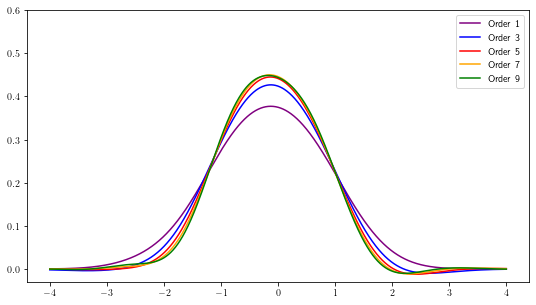

In [ ]:
plt.figure(figsize = (9,5))
plt.ylim([-0.03, 0.6])
plt.plot(X_plot, curve_1_O1,"purple",label="Order 1")
plt.plot(X_plot, curve_1_O3,"b",label="Order 3")
plt.plot(X_plot, curve_1_O5,"r",label="Order 5")
plt.plot(X_plot, curve_1_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_1_O9,"green",label="Order 9")
plt.legend()
#plt.title(r'The number of particle is $2^5$')
plt.savefig('density_simu_particle5.png')



The next cell compares the simulated densities with different kernels for $2^{10}$ particles. 


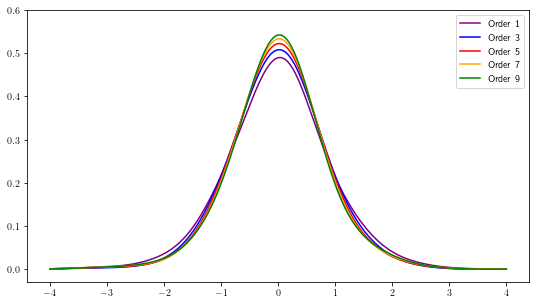

In [ ]:
plt.figure(figsize = (9,5))
plt.ylim([-0.03, 0.6])
plt.plot(X_plot, curve_2_O1,"purple",label="Order 1")
plt.plot(X_plot, curve_2_O3,"b",label="Order 3")
plt.plot(X_plot, curve_2_O5,"r",label="Order 5")
plt.plot(X_plot, curve_2_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_2_O9,"green",label="Order 9")

#plt.title(r'The number of particle is $2^{10}$')
plt.legend()
plt.savefig('density_simu_particle10.png')



The next cell compares the simulated densities with different kernels for $2^{15}$ particles. 


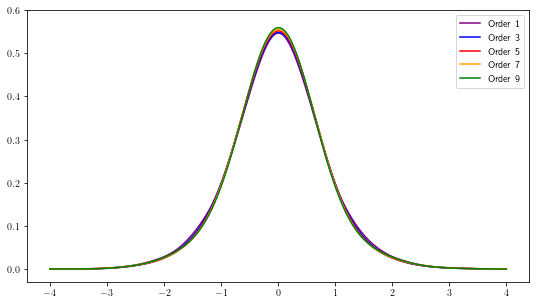

In [ ]:
plt.figure(figsize = (9,5))
plt.ylim([-0.03, 0.6])
plt.plot(X_plot, curve_3_O1,"purple",label="Order 1")
plt.plot(X_plot, curve_3_O3,"b",label="Order 3")
plt.plot(X_plot, curve_3_O5,"r",label="Order 5")
plt.plot(X_plot, curve_3_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_3_O9,"green",label="Order 9")

#plt.title(r'The number of particle is $2^{15}$')
plt.legend()
plt.savefig('density_simu_particle15.png')

